In [1]:
import numpy as np
import pandas as pd
import math
import sys, os
import mplcyberpunk
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color, to_hex
import matplotlib.colors as mc
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import xgboost as xgb

plt.style.use("cyberpunk")

In [2]:
train_time = 1 * 60 * 60
objective = 'xgbhandregressor'

In [4]:
sys.path.append(os.path.realpath('..'))
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [5]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])
features = columns

# Rendering

In [6]:
plt.style.use("cyberpunk")

def render_xgb_features(model):
    histplot_hyperparams = {
            'alpha':0.4,
            #'stat':'percent',
            #'bins':100
            #'kde':True,
        }

    n_cols = 1
    n_rows = 1
    cell_with_dim = 20
    cell_height_dim = 5

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

    fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
    sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=features, **histplot_hyperparams)
    #sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

    mplcyberpunk.make_lines_glow(ax)
    plt.show()

In [7]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None, boarders=None):
    if boarders is not None:
        factor=1.0/max(boarders.values())
        for k in boarders:
            boarders[k] = boarders[k]*factor  
    
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) + 1 / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        print('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []
    
    hc = ['r', 'y', 'g']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)
 

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        
        if boarders is not None:
            c = to_hex(list(colormap(boarders[feature])))
            print(f'feature:{feature} color{c} row:{row} col{col}')
            linewidth = 2
            ax[row, col].spines['bottom'].set_color(c)
            ax[row, col].spines['bottom'].set_linewidth(linewidth)
            ax[row, col].spines['top'].set_color(c)
            ax[row, col].spines['top'].set_linewidth(linewidth)
            ax[row, col].spines['left'].set_color(c)
            ax[row, col].spines['left'].set_linewidth(linewidth)
            ax[row, col].spines['right'].set_color(c)
            ax[row, col].spines['right'].set_linewidth(linewidth)
            #ax[row, col].patch.set_linewidth('1')  
        
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [8]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

def render_cm(matrix):

    hc = ['#212946', '#FE53BB', '#F5D300']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)


    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.title('Confusion Matrix', y=1.08, fontsize = 20)
    res = sns.heatmap(matrix, annot=True, cmap=colormap, ax = ax, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('#08F7FE')

    xticks = ax.get_xticks()
    for i in range(len(xticks)-1):  
        ax.axvline( x=(xticks[i] + xticks[i+1]) / 2, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.5, color='#08F7FE')

    yticks = ax.get_yticks()
    for i in range(len(yticks)-1):  
        ax.axhline( y=(yticks[i] + yticks[i+1]) / 2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=0.5, color='#08F7FE')


    # plt.savefig("Heatmap.png")
    mplcyberpunk.make_lines_glow(ax, diff_linewidth=0.9)
    plt.show()

In [9]:
def feature_by_target(train_df):
    n_cols = 4
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    pad=2
    h_pad=4
    w_pad=None
    n_bins=50

    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }

    colors = ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733', 'g']

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)

    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
    axs = []
    for i, feature in tqdm(enumerate(features)):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols) 
        targets = train_df[target[0]].unique()
        for s, t in enumerate(targets):
            bp = ax[row, col].boxplot(x=train_df[train_df[target[0]] == t][feature], sym='k+', patch_artist=True, positions=[s], widths=cell_with_dim / (cell_with_dim + 2))
            c1 = colors[s]
            c2 = '#ffffff50'
            ax[row, col].set_title(feature)
            for box in bp['boxes']:
                box.set(color=c1, linewidth=1)
                box.set(facecolor=c1)
                r, g, b, a = box.get_facecolor()
                box.set_facecolor((r, g, b, .4)) # alpha layer
            for whisker in bp['whiskers']:
                whisker.set(color=c1, linewidth=1)
            for cap in bp['caps']:
                cap.set(color=c1, linewidth=1)
            for median in bp['medians']:
                median.set(color=c1)
            for flier in bp['fliers']:
                flier.set(color=c1, linewidth=1)
                flier.set(markeredgecolor=c1)

        mplcyberpunk.make_lines_glow(ax[row, col])

        axs.append(ax[row, col].get_legend_handles_labels())

# PreProcessing

In [10]:
classes = train_df[target[0]].unique()
classes

array([6, 7, 5, 4, 8, 3], dtype=int64)

In [11]:
#train_df['tick'] = 1
#train_df.groupby(target[0])['tick'].sum()

In [12]:
scrubbed_df = train_df.copy()
classes = scrubbed_df[target[0]].unique()
for spec_class in classes:
    scrubbed_df[f'bi_{spec_class}'] = 0
    scrubbed_df.loc[scrubbed_df[target[0]] == spec_class, f'bi_{spec_class}'] = 1
scrubbed_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0               8.0              0.50         0.39            2.20      0.073   
1               9.3              0.30         0.73            2.30      0.092   
2               7.1              0.51         0.03            2.10      0.059   
3               8.1              0.87         0.22            2.60      0.084   
4               8.5              0.36         0.30            2.30      0.079   
...             ...               ...          ...             ...        ...   
2051            6.6              0.31         0.13            2.00      0.056   
2052            9.7              0.59         0.21            1.80      0.079   
2053            7.7              0.43         0.42            1.70      0.071   
2054            9.1              0.50         0.00            1.75      0.058   
2055            6.2              0.31         0.18            2.30      0.059   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
Id                                                                          
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
2051                 29.0                  42.0  0.99388  3.52       0.87   
2052                 27.0                  65.0  0.99745  3.14       0.58   
2053                 19.0                  37.0  0.99258  3.32       0.77   
2054                  5.0                  13.0  0.99670  3.22       0.42   
2055                 12.0                  28.0  0.99520  3.56       0.88   

      alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                          
0        12.1        6     1     0     0     0     0     0  
1        12.8        6     1     0     0     0     0     0  
2        11.3        7     0     1     0     0     0     0  
3         9.8        5     0     0     1     0     0     0  
4         9.5        6     1     0     0     0     0     0  
...       ...      ...   ...   ...   ...   ...   ...   ...  
2051     12.0        7     0     1     0     0     0     0  
2052      9.4        5     0     0     1     0     0     0  
2053     12.5        8     0     0     0     0     1     0  
2054      9.5        5     0     0     1     0     0     0  
2055     11.4        7     0     1     0     0     0     0  

[2056 rows x 18 columns]

In [13]:
train_df = scrubbed_df

In [14]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'bi_6', 'bi_7', 'bi_5', 'bi_4',
       'bi_8', 'bi_3'],
      dtype='object')

In [15]:
def add_features(df):
    # From https://www.kaggle.com/competitions/playground-series-s3e5/discussion/383685
    df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
    df['free_sulfur/total_sulfur'] = df['free sulfur dioxide'] / df['total sulfur dioxide']
    df['sugar/alcohol'] = df['residual sugar'] / df['alcohol']
    df['alcohol/density'] = df['alcohol'] / df['density']
    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['bound_sulfur'] = df['total sulfur dioxide'] - df['free sulfur dioxide']
    df['alcohol/pH'] = df['alcohol'] / df['pH']
    df['alcohol/acidity'] = df['alcohol'] / df['total_acid']
    df['alkalinity'] = df['pH'] + df['alcohol']
    df['mineral'] = df['chlorides'] + df['sulphates'] + df['residual sugar']
    df['density/pH'] = df['density'] / df['pH']
    df['total_alcohol'] = df['alcohol'] + df['residual sugar']
    
    # From https://www.kaggle.com/competitions/playground-series-s3e5/discussion/382698
    df['acid/density'] = df['total_acid']  / df['density']
    df['sulphate/density'] = df['sulphates']  / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates*alcohol'] = df['sulphates'] * df['alcohol']
    
    return df
train_df = add_features(train_df)
test_df = add_features(test_df)

In [16]:
train_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'bi_6', 'bi_7', 'bi_5', 'bi_4',
       'bi_8', 'bi_3', 'acidity_ratio', 'free_sulfur/total_sulfur',
       'sugar/alcohol', 'alcohol/density', 'total_acid', 'sulphates/chlorides',
       'bound_sulfur', 'alcohol/pH', 'alcohol/acidity', 'alkalinity',
       'mineral', 'density/pH', 'total_alcohol', 'acid/density',
       'sulphate/density', 'sulphates/acid', 'sulphates*alcohol'],
      dtype='object')

In [17]:
target = ['quality']
columns = train_df.columns.to_list()
columns.remove(target[0])

for i in range(3, 9):
    columns.remove(f'bi_{i}')

features = columns

In [18]:
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'acidity_ratio',
 'free_sulfur/total_sulfur',
 'sugar/alcohol',
 'alcohol/density',
 'total_acid',
 'sulphates/chlorides',
 'bound_sulfur',
 'alcohol/pH',
 'alcohol/acidity',
 'alkalinity',
 'mineral',
 'density/pH',
 'total_alcohol',
 'acid/density',
 'sulphate/density',
 'sulphates/acid',
 'sulphates*alcohol']

In [19]:
train_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0               8.0              0.50         0.39            2.20      0.073   
1               9.3              0.30         0.73            2.30      0.092   
2               7.1              0.51         0.03            2.10      0.059   
3               8.1              0.87         0.22            2.60      0.084   
4               8.5              0.36         0.30            2.30      0.079   
...             ...               ...          ...             ...        ...   
2051            6.6              0.31         0.13            2.00      0.056   
2052            9.7              0.59         0.21            1.80      0.079   
2053            7.7              0.43         0.42            1.70      0.071   
2054            9.1              0.50         0.00            1.75      0.058   
2055            6.2              0.31         0.18            2.30      0.059   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
Id                                                                          
0                    30.0                  39.0  0.99572  3.33       0.77   
1                    30.0                  67.0  0.99854  3.32       0.67   
2                     3.0                  12.0  0.99660  3.52       0.73   
3                    11.0                  65.0  0.99730  3.20       0.53   
4                    10.0                  45.0  0.99444  3.20       1.36   
...                   ...                   ...      ...   ...        ...   
2051                 29.0                  42.0  0.99388  3.52       0.87   
2052                 27.0                  65.0  0.99745  3.14       0.58   
2053                 19.0                  37.0  0.99258  3.32       0.77   
2054                  5.0                  13.0  0.99670  3.22       0.42   
2055                 12.0                  28.0  0.99520  3.56       0.88   

      ...  alcohol/pH  alcohol/acidity  alkalinity  mineral  density/pH  \
Id    ...                                                                 
0     ...    3.633634         1.361080       15.43    3.043    0.299015   
1     ...    3.855422         1.239109       16.12    3.062    0.300765   
2     ...    3.210227         1.479058       14.82    2.889    0.283125   
3     ...    3.062500         1.066376       13.00    3.214    0.311656   
4     ...    2.968750         1.037118       12.70    3.739    0.310762   
...   ...         ...              ...         ...      ...         ...   
2051  ...    3.409091         1.704545       15.52    2.926    0.282352   
2052  ...    2.993631         0.895238       12.54    2.459    0.317659   
2053  ...    3.765060         1.461988       15.82    2.541    0.298970   
2054  ...    2.950311         0.989583       12.72    2.228    0.309534   
2055  ...    3.202247         1.704036       14.96    3.239    0.279551   

      total_alcohol  acid/density  sulphate/density  sulphates/acid  \
Id                                                                    
0             14.30      8.928213          0.773310        1.540000   
1             15.10     10.345104          0.670980        2.233333   
2             13.40      7.666065          0.732490        1.431373   
3             12.40      9.214880          0.531435        0.609195   
4             11.80      9.211214          1.367604        3.777778   
...             ...           ...               ...             ...   
2051          14.00      7.083350          0.875357        2.806452   
2052          11.20     10.526843          0.581483        0.983051   
2053          14.20      8.613915          0.775756        1.790698   
2054          11.25      9.631785          0.421391        0.840000   
2055          13.70      6.722267          0.884244        2.838710   

      sulphates*alcohol  
Id                      

In [20]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))

In [21]:
train_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                              
0          0.724771          0.771429     0.486842        0.921875   0.848259   
1          0.605505          0.914286     0.039474        0.914062   0.800995   
2          0.807339          0.764286     0.960526        0.929688   0.883085   
3          0.715596          0.507143     0.710526        0.890625   0.820896   
4          0.678899          0.871429     0.605263        0.914062   0.833333   
...             ...               ...          ...             ...        ...   
2051       0.853211          0.907143     0.828947        0.937500   0.890547   
2052       0.568807          0.707143     0.723684        0.953125   0.833333   
2053       0.752294          0.821429     0.447368        0.960938   0.853234   
2054       0.623853          0.771429     1.000000        0.957031   0.885572   
2055       0.889908          0.907143     0.763158        0.914062   0.883085   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
Id                                                                    
0                0.567164              0.886525  0.585169  0.432692   
1                0.567164              0.787234  0.378120  0.442308   
2                0.970149              0.982270  0.520558  0.250000   
3                0.850746              0.794326  0.469163  0.557692   
4                0.865672              0.865248  0.679148  0.557692   
...                   ...                   ...       ...       ...   
2051             0.582090              0.875887  0.720264  0.250000   
2052             0.611940              0.794326  0.458150  0.615385   
2053             0.731343              0.893617  0.815712  0.442308   
2054             0.940299              0.978723  0.513216  0.538462   
2055             0.835821              0.925532  0.623348  0.211538   

      sulphates  ...  alcohol/pH  alcohol/acidity  alkalinity   mineral  \
Id               ...                                                      
0      0.756410  ...    0.431272         0.574828    0.374552  0.908482   
1      0.820513  ...    0.321288         0.647128    0.250896  0.907018   
2      0.782051  ...    0.641239         0.504896    0.483871  0.920345   
3      0.910256  ...    0.714497         0.749517    0.810036  0.895309   
4      0.378205  ...    0.760988         0.766861    0.863799  0.854865   
...         ...  ...         ...              ...         ...       ...   
2051   0.692308  ...    0.542623         0.371235    0.358423  0.917495   
2052   0.878205  ...    0.748649         0.850961    0.892473  0.953470   
2053   0.756410  ...    0.366098         0.515014    0.304659  0.947154   
2054   0.980769  ...    0.770132         0.795037    0.860215  0.971266   
2055   0.685897  ...    0.645197         0.371537    0.458781  0.893383   

      density/pH  total_alcohol  acid/density  sulphate/density  \
Id                                                                
0       0.644049       0.743421      0.684203          0.755723   
1       0.626977       0.690789      0.558768          0.821097   
2       0.799058       0.802632      0.795938          0.781801   
3       0.520732       0.868421      0.658824          0.910244   
4       0.529451       0.907895      0.659149          0.376061   
...          ...            ...           ...               ...   
2051    0.806596       0.763158      0.847525          0.690531   
2052    0.462172       0.947368      0.542679          0.878271   
2053    0.644489       0.750000      0.712027          0.754161   
2054    0.541433       0.944079      0.621917          0.980546   
2055    0.833927       0.782895      0.879491          0.684853   

      sulphates/acid  sulphates*alcohol  
Id                                       
0           0.815172           0.686761  
1           0.710977           0.728703  
2           

In [22]:
#scaler = MinMaxScaler().fit(train_df[features])
#X = scaler.transform(train_df[features])
#X_test = scaler.transform(test_df[features])

#scaler = MinMaxScaler().fit(train_df[target])
#Y = scaler.transform(train_df[target])

In [23]:
#shrink for regressor
print(f'Before: {train_df[target[0]].unique()}')
train_df[target[0]] = train_df[target[0]] - np.min(train_df[target[0]].unique())
print(f'After:{train_df[target[0]].unique()}')

Before: [6 7 5 4 8 3]
After:[3 4 2 1 5 0]


# Train

In [24]:
def cohen_kappa_score_proxy(x, y):
    return cohen_kappa_score(x, y, weights='quadratic')

In [34]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((train_df.shape[0],))

for fold, (train_index, test_index) in enumerate(skf.split(train_df, train_df["quality"])):
    print("-------> Fold {} <--------".format(fold + 1))
    predictions = []
    
    for binary_feature in range(3,9):
        print(": Training regressor for binary label {}".format(binary_feature))
        x_train, x_valid = pd.DataFrame(train_df.iloc[train_index]), pd.DataFrame(train_df.iloc[test_index])
        y_train, y_valid = train_df["bi_{}".format(binary_feature)].iloc[train_index], train_df["bi_{}".format(binary_feature)].iloc[test_index]
        y_train_act, y_valid_act = train_df["quality"].iloc[train_index], train_df["quality"].iloc[test_index]

        scaler = MinMaxScaler()
        x_train_features = pd.DataFrame(x_train[features])
        x_train_features[features] = scaler.fit_transform(x_train_features[features])
        x_valid_features = pd.DataFrame(x_valid[features])
        x_valid_features[features] = scaler.transform(x_valid_features[features])

        static_params = {
            'objective':'binary:logistic',
            'tree_method':'gpu_hist',
            'booster':'gbtree',
            'predictor':'gpu_predictor',
            'eval_metric':'auc',
            'n_jobs': -1,
            'early_stopping_rounds': 50
        }

        starting_parms = {'gamma': 1}

        static_params.update(starting_parms)
        
        model = xgb.XGBModel(**static_params)
        
        model.fit(
            x_train_features[features], 
            y_train,
            eval_set=[(x_valid_features[features], y_valid)],
            verbose=0,
        )
        predictions.append(model.predict(x_valid_features[features], ntree_limit=model.best_ntree_limit))
            
    predictions = np.array(predictions)
    oof_preds = np.argmax(predictions, axis=0)
    train_oof_preds[test_index] = oof_preds

    
qwk = cohen_kappa_score(train_df["quality"], train_oof_preds, weights="quadratic")
print("--> Overall results for out of fold predictions")
print(": QWK = {}".format(qwk))

        
        

D:\source\repos\venv\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 12 members, which is less than n_splits=20.
  warnings.warn(


-------> Fold 1 <--------
: Training regressor for binary label 3
[19:45:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:57] WARNING: C:/buildkite-agent/bui

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 2 <--------
: Training regressor for binary label 3
[19:45:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:45:58] WARNING: C:/buildkite-agent/bui

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 3 <--------
: Training regressor for binary label 3
[19:46:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:00] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:00] WARNING: C:/buildkite-agent/bui

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 4 <--------
: Training regressor for binary label 3
[19:46:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:01] WARNING: C:/buildkite-agent/bui

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 5 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8
-------> Fold 6 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 7 <--------
: Training regressor for binary label 3
: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 8 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 9 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 10 <--------
: Training regressor for binary label 3
: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 11 <--------
: Training regressor for binary label 3
: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 12 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 13 <--------
: Training regressor for binary label 3
: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 14 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 15 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8
-------> Fold 16 <--------
: Training regressor for binary label 3


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 17 <--------
: Training regressor for binary label 3
[19:46:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:19] WARNING: C:/buildkite-agent/bu

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5
: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 18 <--------
: Training regressor for binary label 3
[19:46:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:20] WARNING: C:/buildkite-agent/bu

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 19 <--------
: Training regressor for binary label 3
[19:46:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:22] WARNING: C:/buildkite-agent/bu

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 8


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


-------> Fold 20 <--------
: Training regressor for binary label 3
[19:46:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[19:46:23] WARNING: C:/buildkite-agent/bu

D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 4


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 5


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 6


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


: Training regressor for binary label 7
: Training regressor for binary label 8
--> Overall results for out of fold predictions
: QWK = 0.46882453256880174


D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [42]:
train_oof_preds[0:20]

array([3., 3., 3., 2., 2., 2., 3., 2., 3., 2., 2., 3., 2., 2., 3., 2., 4.,
       2., 2., 4.])

In [43]:
classifiers = {}
test_predictions = []
for i in range(3, 9):
    feature_index = i

    scaler = MinMaxScaler().fit(train_df[features])
    X = scaler.transform(train_df[features])

    static_params = {
            'objective':'binary:logistic',
            'tree_method':'gpu_hist',
            'booster':'gbtree',
            'predictor':'gpu_predictor',
            'eval_metric':'auc',
            'n_jobs': -1,
            'early_stopping_rounds': 50
    }

    starting_parms = {'gamma': 1}

    static_params.update(starting_parms)

    print(f'tringing with:{static_params}')

    model = xgb.XGBModel(**static_params)

    X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[f'bi_{feature_index}'], test_size=0.40)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    
    predictions = model.predict(X_valid)

    classifiers[feature_index] = model

    roc_auc = roc_auc_score(y_valid, predictions)
    score = roc_auc
    print(score)

    

predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(train_df[features]))
train_final_preds = np.array(predictions)
score = cohen_kappa_score_proxy(train_df[target], np.argmax(train_final_preds, axis=0))
train_final_preds = np.argmax(train_final_preds, axis=0)
print(f'final {score}')

predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(test_df[features]))
test_final_preds = np.array(predictions)
test_final_preds = np.argmax(test_final_preds, axis=0)


train_final_preds = train_final_preds+3
test_final_preds = test_final_preds+3

train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 1}
0.7985347985347986
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 1}
0.724571933742788
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 1}
0.789951676230746
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'eval_metric': 'auc', 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 1}
0.6622384464850217
tringing with:{'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'booster': 'gbtree', 'predictor': 'gpu_predi

feature:fixed acidity color#489800 row:-1 col0
feature:volatile acidity color#81aa00 row:0 col1
feature:citric acid color#b7bc00 row:0 col2
feature:residual sugar color#138600 row:0 col3
feature:chlorides color#7eaa00 row:0 col0
feature:free sulfur dioxide color#99b200 row:1 col1
feature:total sulfur dioxide color#8cae00 row:1 col2
feature:density color#469700 row:1 col3
feature:pH color#c6ab00 row:1 col0
feature:sulphates color#92b000 row:2 col1
feature:alcohol color#ff0000 row:2 col2
feature:acidity_ratio color#84ac00 row:2 col3
feature:free_sulfur/total_sulfur color#78a800 row:2 col0
feature:sugar/alcohol color#599d00 row:3 col1
feature:alcohol/density color#208a00 row:3 col2
feature:total_acid color#ff0000 row:3 col3
feature:sulphates/chlorides color#9cb300 row:3 col0
feature:bound_sulfur color#65a100 row:4 col1
feature:alcohol/pH color#008000 row:4 col2
feature:alcohol/acidity color#94b100 row:4 col3
feature:alkalinity color#b9bd00 row:4 col0
feature:mineral color#1e8a00 row:5 col

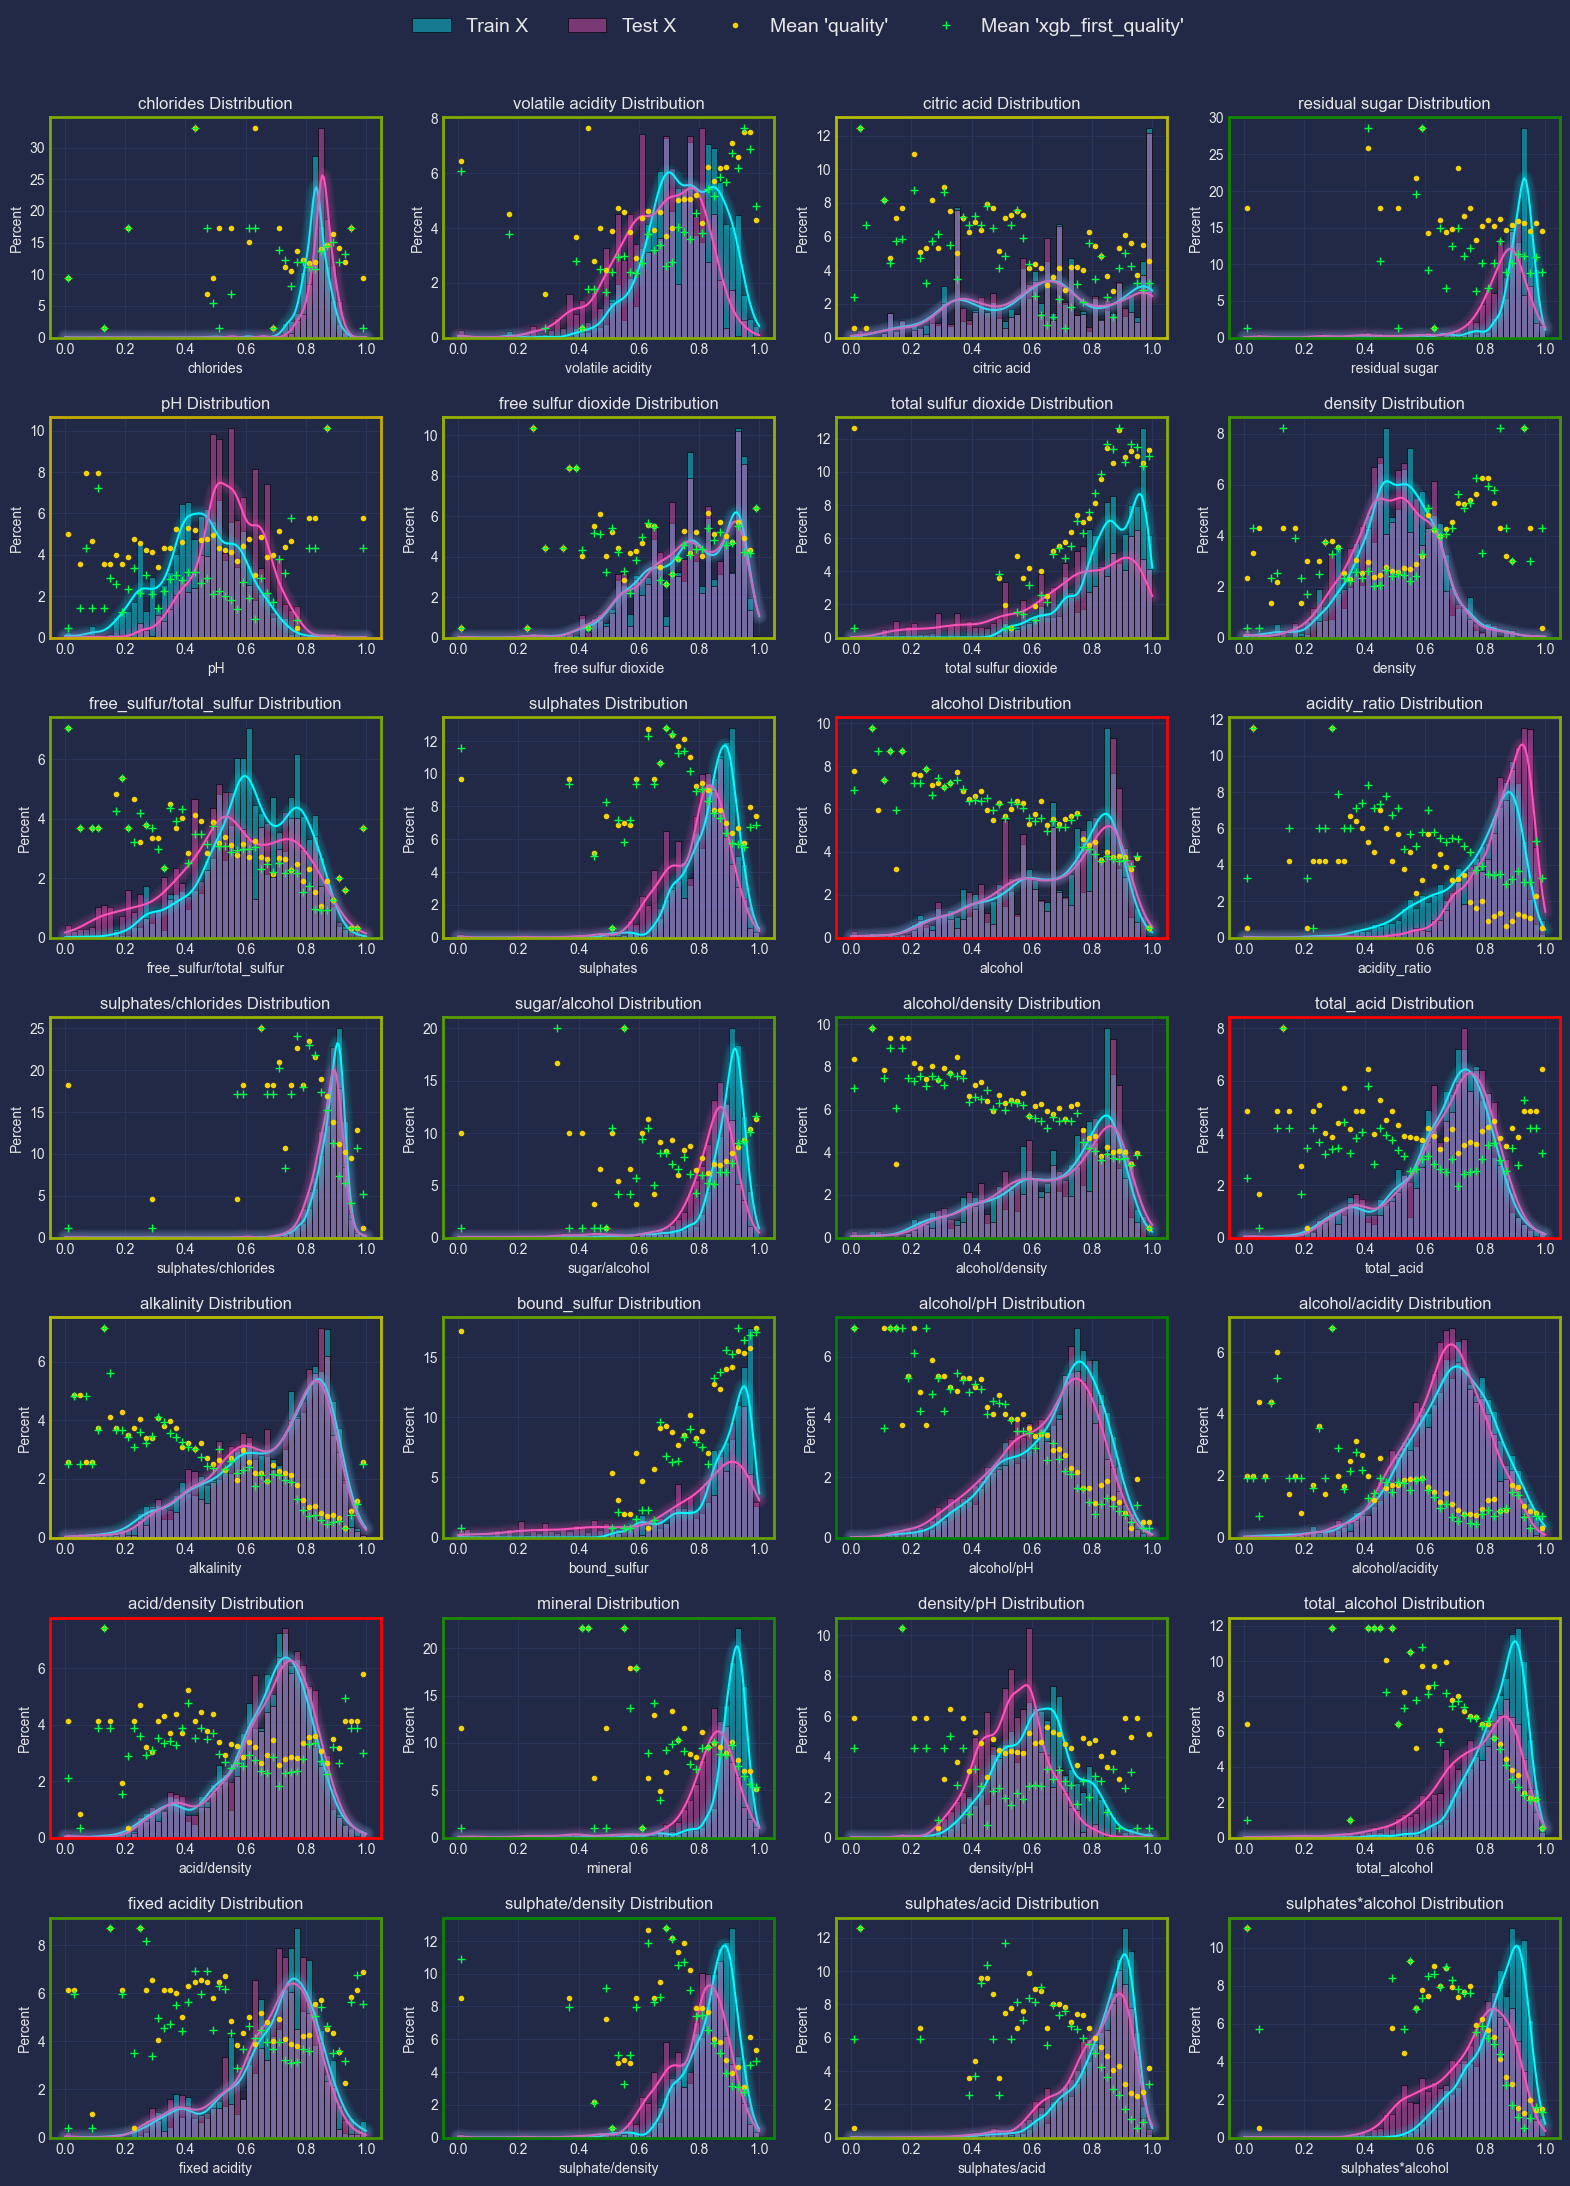

In [162]:
train_df[f'xgb_first_{target[0]}'] = train_final_preds
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=fi_df.loc[0].to_dict())

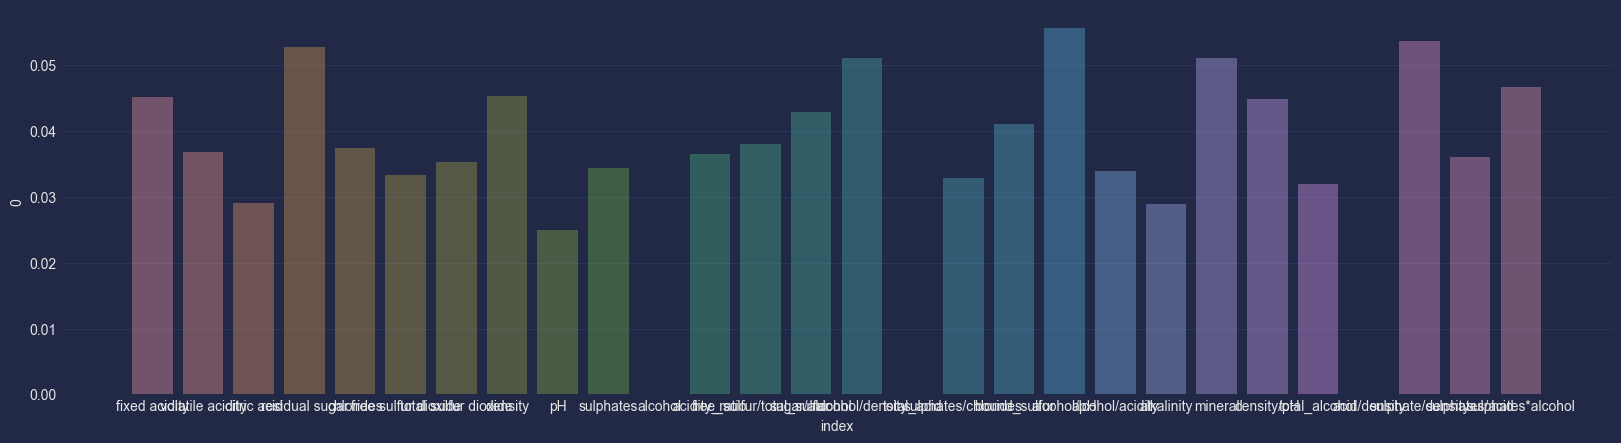

In [163]:
render_xgb_features(model)

In [164]:
predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(train_df[features]))
predictions = np.array(predictions)
predictions[0:5]

array([[0.0143213 , 0.0143213 , 0.0143213 , ..., 0.0143213 , 0.0143213 ,
        0.0143213 ],
       [0.04718346, 0.04718346, 0.04718346, ..., 0.04718346, 0.12207671,
        0.04718346],
       [0.154084  , 0.154084  , 0.154084  , ..., 0.154084  , 0.60541713,
        0.154084  ],
       [0.62325406, 0.7906656 , 0.3799932 , ..., 0.22125477, 0.1216765 ,
        0.2755427 ],
       [0.41079614, 0.49938563, 0.73508745, ..., 0.19272947, 0.03687003,
        0.5068068 ]], dtype=float32)

In [165]:
np.argmax(predictions, axis=0)[0:5]

array([3, 3, 4, 2, 3], dtype=int64)

In [166]:
train_df[target[0]][0:5]

Id
0    3
1    3
2    4
3    2
4    3
Name: quality, dtype: int64

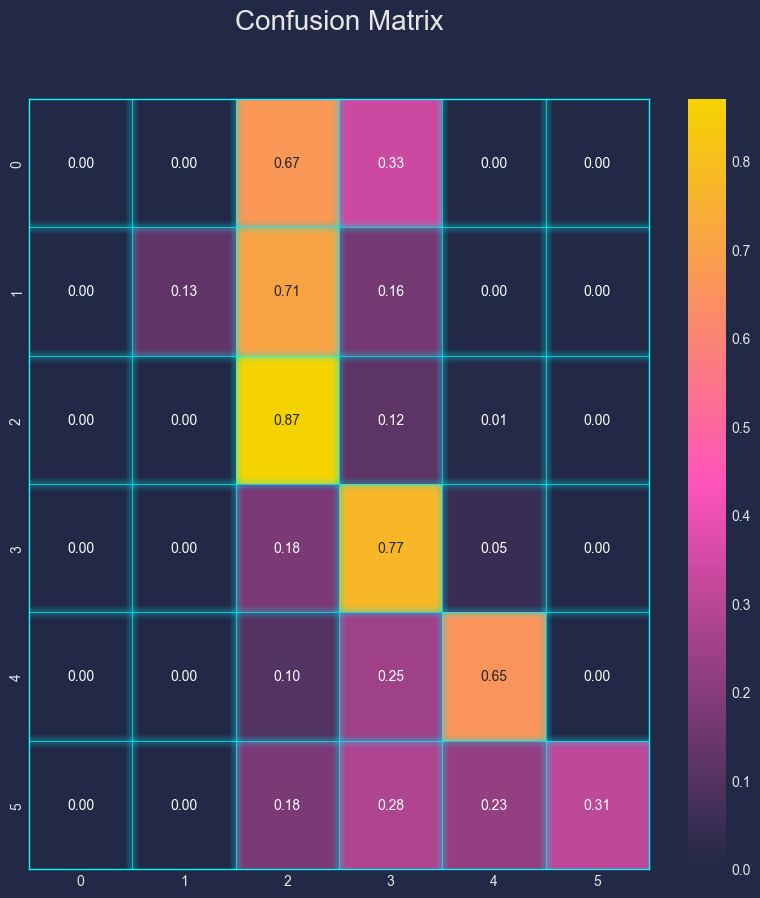

In [167]:
cm = confusion_matrix(train_df[target], np.argmax(predictions, axis=0), normalize='true')
render_cm(cm)

In [168]:
score = cohen_kappa_score_proxy(train_df[target], np.argmax(predictions, axis=0))
print(f'final {score}')

final 0.6953739609688299


In [746]:
np.argmax(predictions, axis=0)

array([3, 3, 3, ..., 4, 2, 3], dtype=int64)

In [747]:
score = cohen_kappa_score_proxy(train_df[target], np.argmax(predictions, axis=0))
print(score)

0.33352523657260824


In [735]:
predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(train_df[features]))
train_final_preds = np.array(predictions)
score = cohen_kappa_score_proxy(train_df[target], np.argmax(train_final_preds, axis=0))
train_final_preds = np.argmax(train_final_preds, axis=0)
print(score)

predictions = []
for i in range(3, 9):
    predictions.append(classifiers[i].predict(test_df[features]))
test_final_preds = np.array(predictions)
test_final_preds = np.argmax(test_final_preds, axis=0)


0.32671162695492817


In [709]:
test_final_preds

array([2, 3, 2, ..., 2, 2, 2], dtype=int64)

In [710]:
train_final_preds = train_final_preds+3
test_final_preds = test_final_preds+3

In [711]:
test_final_preds

array([5, 6, 5, ..., 5, 5, 5], dtype=int64)

In [712]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [659]:
train_df[0:10]

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
Id                                                                            
0        0.724771          0.771429     0.486842        0.921875   0.848259   
1        0.605505          0.914286     0.039474        0.914062   0.800995   
2        0.807339          0.764286     0.960526        0.929688   0.883085   
3        0.715596          0.507143     0.710526        0.890625   0.820896   
4        0.678899          0.871429     0.605263        0.914062   0.833333   
5        0.550459          0.764286     0.421053        0.921875   0.753731   
6        0.798165          0.507143     1.000000        0.914062   0.830846   
7        0.770642          0.821429     0.578947        0.953125   0.865672   
8        0.394495          0.857143     0.276316        0.921875   0.820896   
9        0.743119          0.571429     0.881579        0.921875   0.907960   

    free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
Id                                                                             
0              0.567164              0.886525  0.585169  0.432692   0.756410   
1              0.567164              0.787234  0.378120  0.442308   0.820513   
2              0.970149              0.982270  0.520558  0.250000   0.782051   
3              0.850746              0.794326  0.469163  0.557692   0.910256   
4              0.865672              0.865248  0.679148  0.557692   0.378205   
5              0.567164              0.549645  0.403084  0.644231   0.903846   
6              0.925373              0.960993  0.599853  0.423077   0.865385   
7              0.746269              0.882979  0.593979  0.461538   0.974359   
8              0.761194              0.882979  0.212188  0.586538   0.782051   
9              0.820896              0.921986  0.504405  0.259615   0.935897   

     alcohol  quality  bi_6  bi_7  bi_5  bi_4  bi_8  bi_3  
Id                                                         
0   0.358491        3     1     0     0     0     0     0  
1   0.226415        3     1     0     0     0     0     0  
2   0.509434        4     0     1     0     0     0     0  
3   0.792453        2     0     0     1     0     0     0  
4   0.849057        3     1     0     0     0     0     0  
5   0.830189        2     0     0     1     0     0     0  
6   0.509434        3     1     0     0     0     0     0  
7   0.811321        3     1     0     0     0     0     0  
8   0.792453        3     1     0     0     0     0     0  
9   0.849057        2     0     0     1     0     0     0

In [439]:
static_params = {
        'tree_method':'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 50
}

starting_parms = {'gamma': 5}

static_params.update(starting_parms)

print(f'tringing with:{static_params}')

model = xgb.XGBClassifier(**static_params, eval_metric=cohen_kappa_score_proxy)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.50)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = model.predict(train_df[features])
score = cohen_kappa_score_proxy(train_df[target], predictions)
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 50, 'gamma': 5}
0.5239821431751914


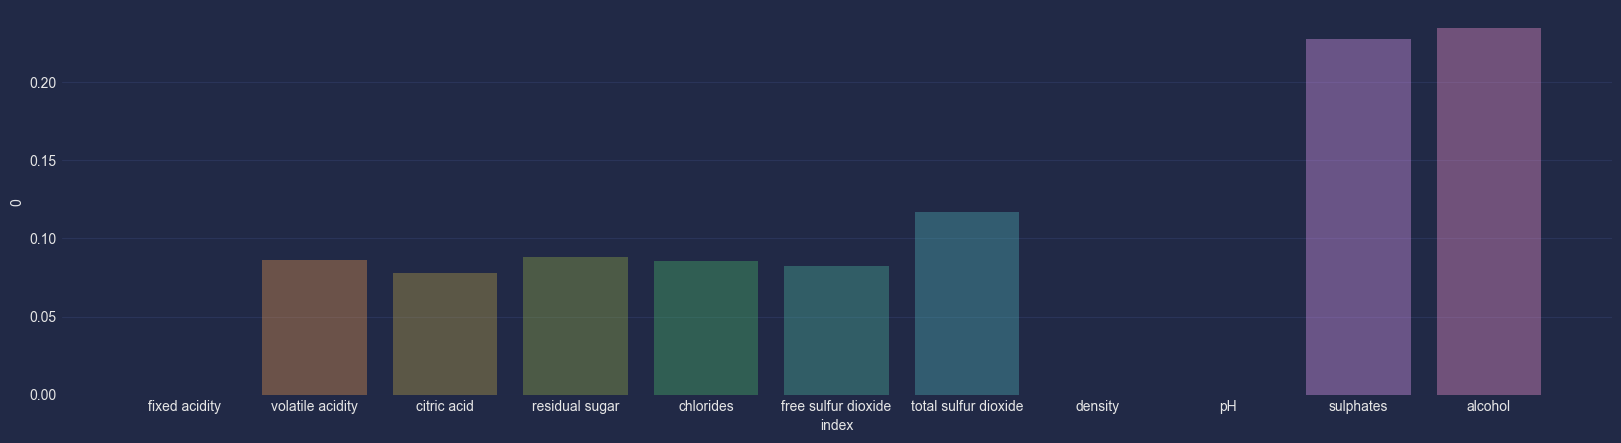

In [440]:
render_xgb_features(model)

In [441]:
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
fi_df.loc[0].to_dict()

{'fixed acidity': 0.0,
 'volatile acidity': 0.08620231598615646,
 'citric acid': 0.07801324129104614,
 'residual sugar': 0.08802979439496994,
 'chlorides': 0.08570964634418488,
 'free sulfur dioxide': 0.0823662206530571,
 'total sulfur dioxide': 0.11724639683961868,
 'density': 0.0,
 'pH': 0.0,
 'sulphates': 0.22760534286499023,
 'alcohol': 0.23482708632946014}

feature:fixed acidity color#ff0000 row:-1 col0
feature:volatile acidity color#d08b00 row:0 col1
feature:citric acid color#d48000 row:0 col2
feature:residual sugar color#d08e00 row:0 col3
feature:chlorides color#d08b00 row:0 col0
feature:free sulfur dioxide color#d28500 row:1 col1
feature:total sulfur dioxide color#c0be00 row:1 col2
feature:density color#ff0000 row:1 col3
feature:pH color#ff0000 row:1 col0
feature:sulphates color#0b8300 row:2 col1
feature:alcohol color#008000 row:2 col2


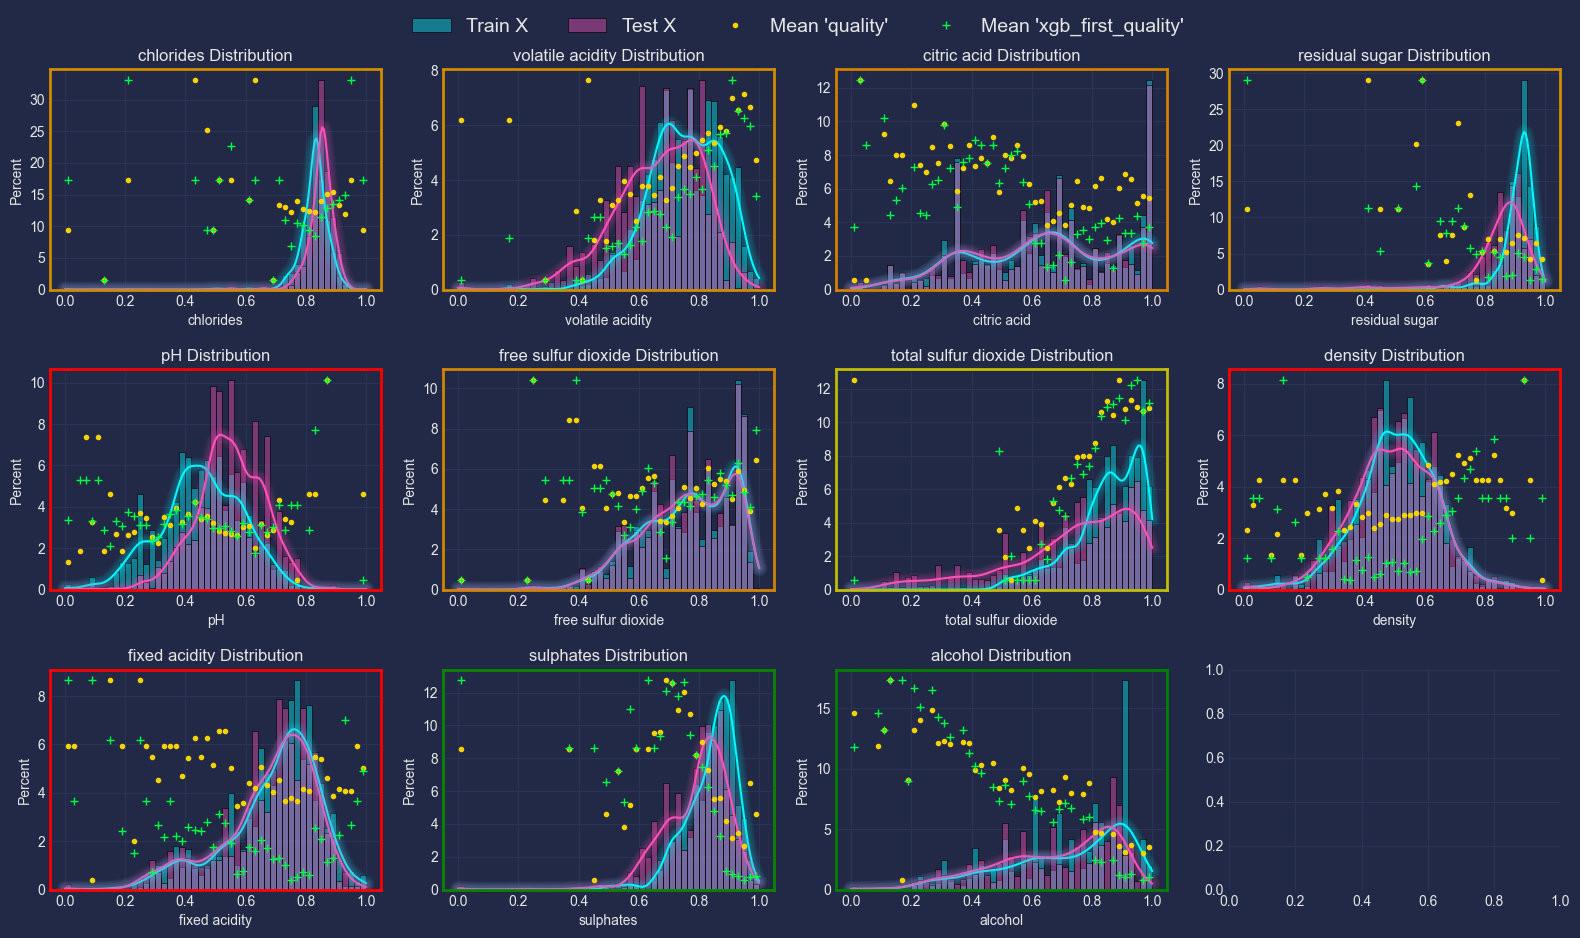

In [442]:
train_df[f'xgb_first_{target[0]}'] = predictions
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=fi_df.loc[0].to_dict())

In [687]:
cm = confusion_matrix(train_df[target[0]], predictions, normalize='true')
render_cm(cm)

ValueError: Found input variables with inconsistent numbers of samples: [2056, 6]

In [688]:
train_final_preds = model.predict(train_df[features])+3
test_final_preds = model.predict(test_df[features])+3

In [689]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [72]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params, eval_metric=cohen_kappa_score_proxy), param_grid = param_test1, cv=5, verbose=10)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, min_child_weight=1............................
[0]	validation_0-mlogloss:1.50760	validation_0-cohen_kappa_score_proxy:0.41634
[1]	validation_0-mlogloss:1.35142	validation_0-cohen_kappa_score_proxy:0.48918
[2]	validation_0-mlogloss:1.25343	validation_0-cohen_kappa_score_proxy:0.51248
[3]	validation_0-mlogloss:1.18304	validation_0-cohen_kappa_score_proxy:0.53465
[4]	validation_0-mlogloss:1.13498	validation_0-cohen_kappa_score_proxy:0.51195
[5]	validation_0-mlogloss:1.09822	validation_0-cohen_kappa_score_proxy:0.50587
[6]	validation_0-mlogloss:1.07034	validation_0-cohen_kappa_score_proxy:0.51783
[7]	validation_0-mlogloss:1.04882	validation_0-cohen_kappa_score_proxy:0.50669
[8]	validation_0-mlogloss:1.03407	validation_0-cohen_kappa_score_proxy:0.50793
[9]	validation_0-mlogloss:1.02528	validation_0-cohen_kappa_score_proxy:0.53095
[10]	validation_0-mlogloss:1.01664	validation_0-cohen_kappa_score_pr

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=50,
                                     enable_categorical=False,
                                     eval_metric=<function cohen_kappa_score_proxy at 0x0000014ACD802D40>,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     i...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             verbose=10)

In [73]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [74]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [75]:
gsearch1.best_score_

0.5950069645344478

In [76]:
gsearch1.__dict__

{'scoring': None,
 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=50,
               enable_categorical=False,
               eval_metric=<function cohen_kappa_score_proxy at 0x0000014ACD802D40>,
               feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=-1,
               num_parallel_tree=None, objective='multi:softmax', predictor=None, ...),
 'n_jobs': None,
 'refit': True,
 'cv': 5,
 'verbose': 10,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': Fa

In [81]:
predictions = gsearch1.best_estimator_.predict(train_df[features])
score = cohen_kappa_score_proxy(train_df[target], predictions)
print(score)

0.5030886977370426


In [52]:

static_params.update(gsearch1.best_params_)
print(f'tringing with:{static_params}')
eval_model = xgb.XGBClassifier(**static_params)
X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
eval_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = eval_model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions, weights='quadratic')
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 20000, 'max_depth': 3, 'min_child_weight': 1}
0.4726783631800887


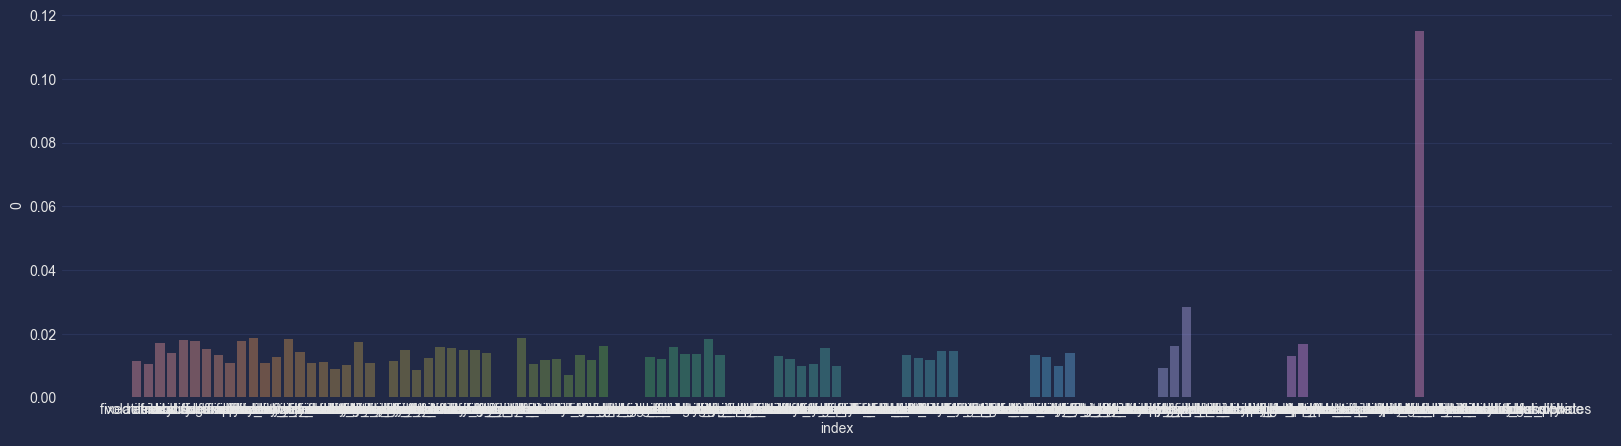

In [53]:
render_xgb_features(model)

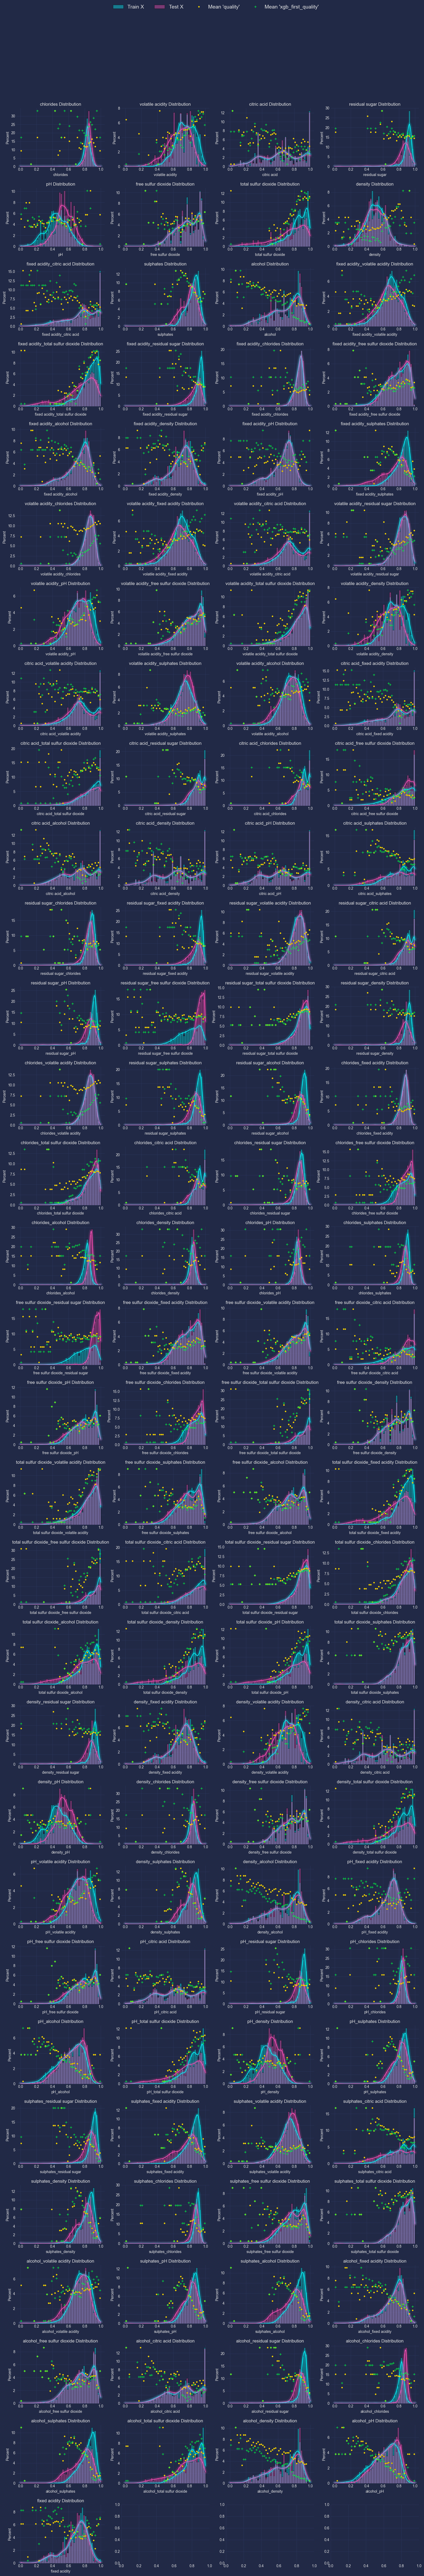

In [54]:
train_df[f'xgb_first_{target[0]}'] = predictions
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'])

In [106]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)

ValueError: Found input variables with inconsistent numbers of samples: [2056, 6]